*First compiled on May 25, 2017.*

# Graph abstraction for hematopoiesis in mouse [(Nestorowa *et al.*, 2016)](https://doi.org/10.1182/blood-2016-05-716480)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy.api as sc

sc.settings.verbosity = 2                # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_dpi(60)                  # low pixel number yields small inline figures
sc.logging.print_version_and_date()
results_file = './write/nestorowa16.h5'

Running Scanpy 0.3 on 2017-11-17 02:10.


Data is available from [blood.stemcells.cam.ac.uk/single_cell_atlas](http://blood.stemcells.cam.ac.uk/single_cell_atlas).

## Preprocessing

In [2]:
path = './data/nestorowa16/data/'

In [3]:
adata = sc.read(path + 'nestorowa_corrected_log2_transformed_counts.txt', cache=True)

reading cache ./write/data/nestorowa16/data/nestorowa_corrected_log2_transformed_counts.h5


In [4]:
acronyms = {
    'ESLAM': 'Stem',
    'Erythroid': 'Ery',
    'Megakaryocytes': 'Mk',
    'Basophils': 'Baso',
    'Neutrophils': 'Neu',
    'Monocytes': 'Mo',
    'Bcell': 'B'
}
exp_groups = pd.read_csv(path + 'nestorowa_corrected_population_annotation.txt',
                         delimiter=' ')

In [5]:
exp_groups = [acronyms[exp_groups.loc[cell_id, 'celltype']]
              if cell_id in exp_groups.index else 'no_gate' for cell_id in adata.smp_names]
adata.smp['exp_groups'] = exp_groups

In [6]:
sc.pp.recipe_weinreb16(adata)
adata.uns['iroot'] = np.flatnonzero(adata.smp['exp_groups'] == 'Stem')[0]

In [7]:
sc.tl.draw_graph(adata, n_neighbors=4)
sc.tl.tsne(adata)
sc.write(results_file, adata)

drawing single-cell graph using layout "fr"
    using "X_pca" for building graph
    computing data graph with n_neighbors = 4 
    computing spectral decomposition ("diffmap") with 15 components
    eigenvalues of transition matrix
    [ 1.            0.9903499484  0.987945199   0.9850011468  0.9819026589
      0.9786074758  0.9733639956  0.9720330834  0.965811491   0.9576765299
      0.9540973902  0.9476533532  0.9379127622  0.9366859794  0.9313570261]
    finished (0:00:25.848) and added
    "X_draw_graph_fr", graph_drawing coordinates (adata.smp)
    "draw_graph_params", the parameters (adata.uns)
computing tSNE
    using X_pca for tSNE
    using 50 principal components
    using the "MulticoreTSNE" package by Ulyanov (2017)
    finished (0:00:07.060):  added
    "X_tsne", tSNE coordinates (adata.smp)


Setting color of group no_gate in exp_groups to grey as it appears in`sc.settings._ignore_categories`.
... you are using a very low resolution for saving figures, adjusting to dpi=300
saving figure to file ./figures/draw_graph_fr.png


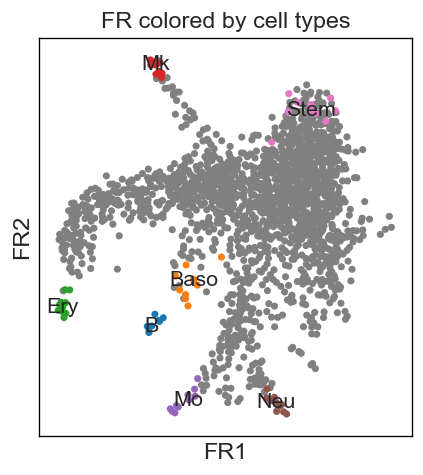

saving figure to file ./figures/tsne.png


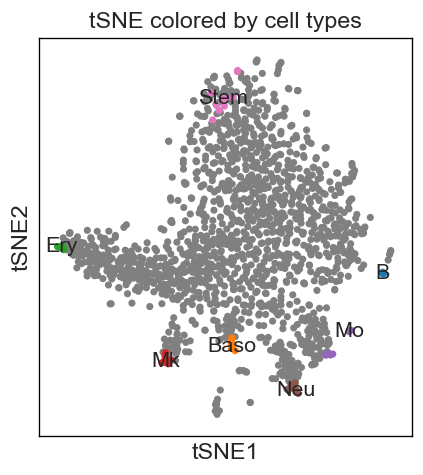

In [8]:
adata = sc.read(results_file)
ax = sc.pl.draw_graph(adata, color='exp_groups', title='FR colored by cell types',
                      legend_loc='on data', save=True)
ax = sc.pl.tsne(adata, color='exp_groups', title='tSNE colored by cell types',
                legend_loc='on data', save=True)

In [9]:
sc.write(results_file, adata)

Export for comparison with Monocle 2.

In [10]:
adata_raw = sc.read(path + 'nestorowa_corrected_log2_transformed_counts.txt', cache=True)
adata_raw.uns['exp_groups_colors'] = adata.uns['exp_groups_colors']
sc.write(results_file[:-3] + '_raw.csv', adata_raw)

reading cache ./write/data/nestorowa16/data/nestorowa_corrected_log2_transformed_counts.h5
writing csv files to ./write/nestorowa16_raw/


## Estimate connectivity of cell groups using graph abstraction

We use the same number of neighbors as for visualizing the data above and as in [*paul15*](../paul15).

In [11]:
adata = sc.read(results_file)
sc.tl.aga(adata, n_neighbors=4, resolution=1.4)
sc.write(results_file, adata)

running Louvain clustering
    using "X_pca" for building graph
    using stored data graph with n_neighbors = 4 and spectrum
    [ 1.            0.9903499484  0.987945199   0.9850011468  0.9819026589
      0.9786074758  0.9733639956  0.9720330834  0.965811491   0.9576765299]
    using the "louvain" package of Traag (2017)
    finished (0:00:00.191): found 19 clusters and added
    'louvain_groups', the cluster labels (adata.smp, dtype=category)
running Approximate Graph Abstraction (AGA)
    using "X_pca" for building graph
    using stored data graph with n_neighbors = 4 and spectrum
    [ 1.            0.9903499484  0.987945199   0.9850011468  0.9819026589
      0.9786074758  0.9733639956  0.9720330834  0.965811491   0.9576765299]
    abstracted graph will have 19 nodes
    finished (0:00:00.414)


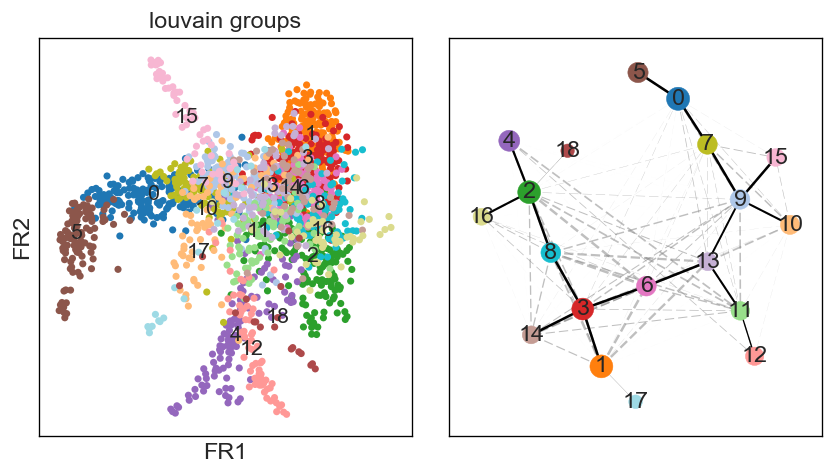

In [12]:
adata = sc.read(results_file)
axs = sc.pl.aga(adata, basis='draw_graph_fr', layout='fr')

Ignoring category 'no_gate' as it's in `settings._ignore_categories`.
saving figure to file ./figures/aga_graph.png


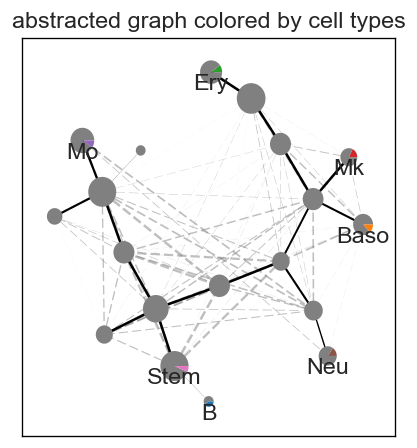

In [13]:
adata = sc.read(results_file)
aga_groups = adata.uns['aga_groups_key']
asso_names, asso_matrix = sc.utils.compute_association_matrix_of_groups(
    adata, prediction=aga_groups, reference='exp_groups', normalization='prediction')
asso_colors = sc.utils.get_associated_colors_of_groups(adata.uns['exp_groups_colors'], asso_matrix)
axs = sc.pl.aga_graph(adata,
                      title='abstracted graph colored by cell types',
                      color=asso_colors, groups=asso_names, layout='fr', save=True)

Ignoring category 'no_gate' as it's in `settings._ignore_categories`.
exporting to ./write/aga_graph.gexf


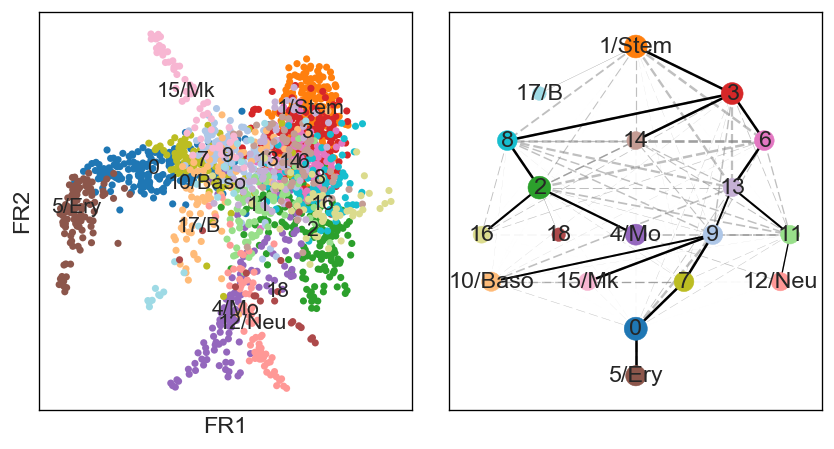

In [14]:
adata = sc.read(results_file)
asso_names, asso_matrix = sc.utils.compute_association_matrix_of_groups(
    adata, prediction=aga_groups, reference='exp_groups',
    normalization='prediction', max_n_names=2)
adata.smp[aga_groups].cat.categories = [
    '{}'.format(name) + ('/{}'.format(asso_names[iname][1:])
     if len(asso_names[iname]) > 0 else '') # replace integers
     for iname, name in enumerate(adata.smp[aga_groups].cat.categories)]
axs = sc.pl.aga(adata, title='',
                basis='draw_graph_fr',
                root=1,
                layout='eq_tree', export_to_gexf=True)

Use Gephi to manually adjust the positions of the nodes. Within Gephi, read in in the positions from the exported '.gexf' file.

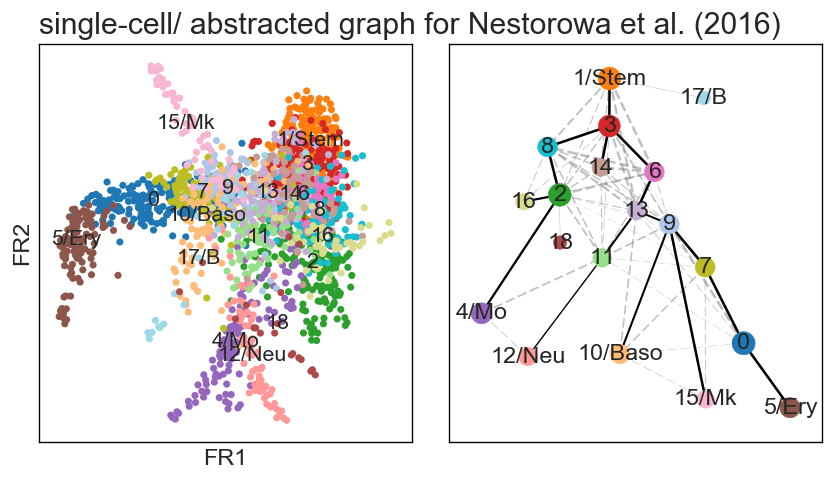

In [15]:
axs = sc.pl.aga(adata, title='', threshold_dashed=0.1,
                basis='draw_graph_fr',
                show=False,
                pos='./write/aga_graph_gephi_nestorowa16.gdf')
axs[0].set_title('single-cell/ abstracted graph for Nestorowa et al. (2016)', loc='left', fontsize=18)
pl.savefig('./figures/aga_gephi.svg')
pl.show()

Ignoring category 'no_gate' as it's in `settings._ignore_categories`.
saving figure to file ./figures/aga_graph.png


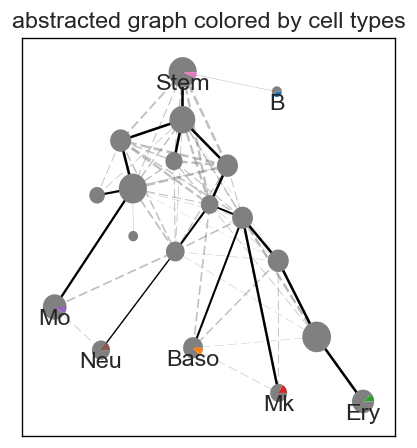

In [16]:
adata = sc.read(results_file)
asso_names, asso_matrix = sc.utils.compute_association_matrix_of_groups(
    adata, prediction=aga_groups, reference='exp_groups', normalization='prediction')
asso_colors = sc.utils.get_associated_colors_of_groups(adata.uns['exp_groups_colors'], asso_matrix)
axs = sc.pl.aga_graph(adata, threshold_dashed=0.1,
                      pos='./write/aga_graph_gephi_nestorowa16.gdf',
                      title='abstracted graph colored by cell types',
                      color=asso_colors, groups=asso_names, layout='fr', save=True)

In [17]:
sc.write('./write/nestorowa16.csv', adata)

writing csv files to ./write/nestorowa16/


## Reconstruct gene changes for some marker genes.

Some marker genes.

| cell type | marker |
| --- | --- |
| Erythroids | Gata1, Gypa, Hba-a2, Hba-a1 |
|Megakaryocytes | Itga2b (encodes protein CD41), Pbx1, Sdpr, Vwf |
|Basophils | Prss34, Ms4a2, Fcer1a, Siglecf |
|Monocytes | Irf8, Csf1r, Ctsg, Mpo |
|Neutrophils | Elane, Ctsg, Mpo, Gfi1 | 
|B cells | Cd19, Vpreb2, Cd79a |

In [18]:
adata = sc.read(results_file)
adata_all_genes = adata_raw = sc.read(path + 'nestorowa_corrected_log2_transformed_counts.txt', cache=True)
adata_all_genes.smp[aga_groups] = adata.smp[aga_groups]
adata_all_genes.smp['aga_pseudotime'] = adata.smp['aga_pseudotime']

reading cache ./write/data/nestorowa16/data/nestorowa_corrected_log2_transformed_counts.h5


In [19]:
gene_names = ['Gata2', 'Gata1', 'Hba-a2', 'Gfi1', 'Elane', 'Irf8', 'Csf1r']

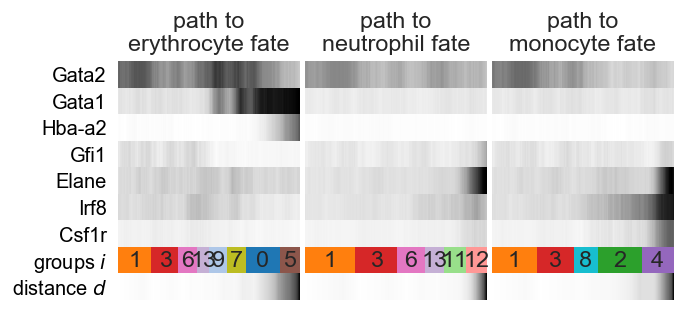

In [20]:
adata = sc.read(results_file)
paths = [('erythrocytes', [1, 3, 6, 13, 9, 7, 0, 5]),
         ('neutrophils', [1, 3, 6, 13, 11, 12]),
         ('monocytes', [1, 3, 8, 2, 4])]
rcParams['figure.figsize'] = (6, 2.5)
rcParams['figure.subplot.top'] = 0.82
rcParams['figure.subplot.bottom'] = 0.2
rcParams['figure.subplot.right'] = 0.92
_, axs = pl.subplots(ncols=3, gridspec_kw={'wspace': 0.03})
for ipath, (descr, path) in enumerate(paths):
    _, data = sc.pl.aga_path(adata_all_genes,
                             groups='louvain_groups',
                             ax=axs[ipath],
                             left_margin=0.15,
                             nodes=path,
                             ytick_fontsize=12,
                             keys=gene_names,
                             n_avg=50,
                             show_yticks=True if ipath==0 else False,
                             show_colorbar=False,
                             title='path to\n{} fate'.format(descr[:-1]),
                             return_data=True, show=False)
    data.to_csv('./write/aga_path_{}.csv'.format(descr))
pl.savefig('./figures/aga_path.svg', dpi=300)
pl.show()
sc.pl.reset_rcParams()